In [1]:
#importing libraries 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor



In [2]:
#read in data
data = pd.read_csv('data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#data cleaning
# lets start cleaning! get your mop & broom! 

#make a copy of the dataset, we never want to overwrite our OG data 
df = data.copy()
# pull out grade code 
df['grade_num'] = data['grade'].map(lambda x:x.split(' ', 1)[0])
#bed bath ratio 
df['bed_bath_ratio'] = df['bedrooms']/df['bathrooms']
#dropping unnecessary columns: give reasons for why 
df = df.drop(columns = ['sqft_basement', 'yr_renovated', 'lat', 'long', 'view', 'condition','grade', 'date'])


#let's dummy variable for city --> 1 for in city of seatlle, 0 for outside of city limits 
#creating a list of zipcodes thar are IN the city limits of seatlle
zip_city_list = [98101, 98177, 98133, 98155, 98125, 98117, 98103, 98107, 98105, 98195, 98199, 98119, 98109, 98102, 98112, 98121, 98122, 98104, 98134, 98144, 98136, 98126, 98106, 98108, 98118, 98146, 98178]
#if it is within our city limits give it a 1,without give it 0 
df['zip_city'] = np.where(df['zipcode'].isin(zip_city_list),1,0)



#let's dummy waterfront 
# assumotion: ATM it's that it's unknown 
    #NaN meaning?--> express this as a % of missing --> report this as a data limitation; llimitations might be that some of the nans might have unreported waterfronts, based off this analyssis we will do --> we could do a ttest with a random sample of Nans and see how mnay of them do have a water front --> we have this % certainty that these nans are nos
df['waterfront'] = df['waterfront'].fillna("Unknown")
#getting dummy variables for waterfront 0= no water, 1 = yes
df1 = pd.get_dummies(df['waterfront'])
#adding dummies into a main dataframe 
main_df = pd.concat([df, df1], axis=1)
#cleaning up the columns so that we have a cleam copy
main_df['Waterfront'] = main_df['YES'].copy()
#dropping unneeded columns 
main_df = main_df.drop(columns = ['NO', 'Unknown', 'YES', 'waterfront', 'zipcode', 'yr_built'])
#store the mean of price because that is the best predictor 
mean_price = main_df['price'].mean()
main_df['mean_price'] = main_df['price'].mean()

main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              21597 non-null  int64  
 1   price           21597 non-null  float64
 2   bedrooms        21597 non-null  int64  
 3   bathrooms       21597 non-null  float64
 4   sqft_living     21597 non-null  int64  
 5   sqft_lot        21597 non-null  int64  
 6   floors          21597 non-null  float64
 7   sqft_above      21597 non-null  int64  
 8   sqft_living15   21597 non-null  int64  
 9   sqft_lot15      21597 non-null  int64  
 10  grade_num       21597 non-null  object 
 11  bed_bath_ratio  21597 non-null  float64
 12  zip_city        21597 non-null  int64  
 13  Waterfront      21597 non-null  uint8  
 14  mean_price      21597 non-null  float64
dtypes: float64(5), int64(8), object(1), uint8(1)
memory usage: 2.3+ MB


In [4]:
#remove outliers

#make a copy of the clean dataframe 
no_out = main_df.copy()

#drop columns that we cannot use 
no_out = no_out.drop(columns= ['id', 'zip_city', 'Waterfront'], axis=1)

#change data type so that we can math 
no_out = no_out.astype('float')

#pull out the columns 
columns = no_out.columns

#for each column in the dataframe, get the mean and standard deviation 
#then get the z-score for within 3 standard devaitions
for col in columns:
        
        mean = no_out[col].mean()
        sd = no_out[col].std()
        
        no_out = no_out[(no_out[col] <= mean+(3*sd))]
        
pd.set_option('display.float_format', lambda x: '%.5f' % x)
no_out.info()


#part of this loop is courtesy of Stephen Allwright 

#https://stephenallwright.com/remove-outliers-pandas/

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19479 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           19479 non-null  float64
 1   bedrooms        19479 non-null  float64
 2   bathrooms       19479 non-null  float64
 3   sqft_living     19479 non-null  float64
 4   sqft_lot        19479 non-null  float64
 5   floors          19479 non-null  float64
 6   sqft_above      19479 non-null  float64
 7   sqft_living15   19479 non-null  float64
 8   sqft_lot15      19479 non-null  float64
 9   grade_num       19479 non-null  float64
 10  bed_bath_ratio  19479 non-null  float64
 11  mean_price      19479 non-null  float64
dtypes: float64(12)
memory usage: 1.9 MB


In [5]:
#add the no_out data back into the full clean dataframe 

not_out = main_df.copy()

#drop the columns that we have cleaned for outliers 
not_out = not_out.drop(columns= ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'grade_num', 'bed_bath_ratio','mean_price'], axis=1)

#add the outliers & no-outlier data frames together so that we have all our columns again 

#we could have done a merge here (left right or inner)
clean_df = pd.concat([no_out, not_out], axis=1)

#drop the null values (for the columns that we did not do the outlier math on )
clean_df = clean_df.dropna()

#check to make sure that we have all our columns with the same amount of data
clean_df.info()

#store our cleaned data as a csv file for future use
clean_df.to_csv('clean_df.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19479 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           19479 non-null  float64
 1   bedrooms        19479 non-null  float64
 2   bathrooms       19479 non-null  float64
 3   sqft_living     19479 non-null  float64
 4   sqft_lot        19479 non-null  float64
 5   floors          19479 non-null  float64
 6   sqft_above      19479 non-null  float64
 7   sqft_living15   19479 non-null  float64
 8   sqft_lot15      19479 non-null  float64
 9   grade_num       19479 non-null  float64
 10  bed_bath_ratio  19479 non-null  float64
 11  mean_price      19479 non-null  float64
 12  id              19479 non-null  int64  
 13  zip_city        19479 non-null  int64  
 14  Waterfront      19479 non-null  uint8  
dtypes: float64(12), int64(2), uint8(1)
memory usage: 2.2 MB


In [6]:
#scale the data 
clean_df = pd.read_csv('clean_df.csv')

clean_df = clean_df.drop(columns = ['Unnamed: 0'])


# Instantiate a new scaler
scaler = StandardScaler()
#.invert_transform

# scaling for STD 
scaler.fit(clean_df)
#scaler.invert_transform(scaled_df)


#Apply the scale to all the data 
scaled_df = scaler.transform(clean_df)


scaled_df = pd.DataFrame(scaled_df,
                              columns=clean_df.columns,
                              index=clean_df.index)
scaled_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_living15,sqft_lot15,grade_num,bed_bath_ratio,mean_price,id,zip_city,Waterfront
0,-1.11572,-0.35178,-1.55982,-1.06182,-0.38158,-0.87574,-0.73923,-0.97564,-0.42036,-0.53006,2.24346,0.00000,0.85470,1.39436,-0.05696
1,0.20606,-0.35178,0.28724,0.85057,-0.22479,0.97252,0.73756,-0.37210,-0.14983,-0.53006,-0.70765,0.00000,0.60609,1.39436,-0.05696
2,-1.29093,-1.52070,-1.55982,-1.62591,0.04682,-0.87574,-1.35083,1.40403,-0.09230,-1.53621,0.47280,0.00000,0.33406,-0.71718,-0.05696
3,0.48204,0.81715,1.39548,0.01132,-0.44559,-0.87574,-0.93315,-0.94115,-0.50876,-0.53006,-0.70765,0.00000,-0.75892,1.39436,-0.05696
4,0.08897,-0.35178,-0.08217,-0.37391,-0.14227,-0.87574,0.00662,-0.18242,-0.16833,0.47608,-0.41254,0.00000,-0.94412,-0.71718,-0.05696


# Regressions

In [7]:
import numpy as np
from sklearn.dummy import DummyRegressor

dummymodel = DummyRegressor(strategy = 'mean')

X = scaled_df.drop(labels = ['grade_num', 'price'], axis=1)
y = scaled_df.price

print(dummymodel.fit(X,y))

print(dummymodel.score(X,y))

y_pred = dummymodel.predict(X)

print(y_pred)

print(y.mean)

print(y - y_pred)

DummyRegressor()
0.0
[-2.04273285e-17 -2.04273285e-17 -2.04273285e-17 ... -2.04273285e-17
 -2.04273285e-17 -2.04273285e-17]
<bound method Series.mean of 0       -1.11572
1        0.20606
2       -1.29093
3        0.48204
4        0.08897
          ...   
19474   -0.53825
19475   -0.37099
19476   -0.36221
19477   -0.37099
19478   -0.68461
Name: price, Length: 19479, dtype: float64>
0       -1.11572
1        0.20606
2       -1.29093
3        0.48204
4        0.08897
          ...   
19474   -0.53825
19475   -0.37099
19476   -0.36221
19477   -0.37099
19478   -0.68461
Name: price, Length: 19479, dtype: float64


In [8]:
#bivariate model 
X6a = scaled_df[['grade_num','sqft_living']]
X6a = sm.add_constant(X)
y6a = scaled_df['price']

model6 = ols('price ~ grade_num + sqft_living', data=scaled_df)
model6_results = model6.fit()
print(model6_results.summary())

#the Durbin-Watson score is 1.955, meaning that autocorrelation is likley not a cause for concern here. therefore the independence assumptions has been met. 
params = model6_results.params
#model6_results.predict(exog= "grade_num + sqft_living"))
    
     #y_hat
#y-true(price) - y_hat --> sqaure that --> root that 
#RMSE is off by so many errors 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     7670.
Date:                Thu, 15 Sep 2022   Prob (F-statistic):               0.00
Time:                        08:31:11   Log-Likelihood:                -21982.
No. Observations:               19479   AIC:                         4.397e+04
Df Residuals:                   19476   BIC:                         4.399e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -3.89e-18      0.005  -7.26e-16      

In [9]:
#model 24 
# same as model 23 but dropping floors 
# mulit: price & grade_num + swft_liv + water + zip + sqftliv15 + sqftabove 
X = scaled_df[['grade_num', 'sqft_living', 'Waterfront', 'sqft_living15', 'sqft_above', 'zip_city']]
X = sm.add_constant(X)
y = scaled_df['price']

model24 = ols('price ~  grade_num + sqft_living + Waterfront + sqft_living15 + sqft_above + zip_city', data=scaled_df)
model24_results = model24.fit()
print(model24_results.summary())

#best R-sqaured so far!!
#the Durbin-Watson score is 1.950, meaning that autocorrelation is likley not a cause for concern here. therefore the independence assumptions has been met. 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     3510.
Date:                Thu, 15 Sep 2022   Prob (F-statistic):               0.00
Time:                        08:32:08   Log-Likelihood:                -20499.
No. Observations:               19479   AIC:                         4.101e+04
Df Residuals:                   19472   BIC:                         4.107e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.863e-17      0.005  -3.75e-15

# Train Test Split Attempt
code from https://builtin.com/data-science/train-test-split

In [22]:
clean_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_living15,sqft_lot15,grade_num,bed_bath_ratio,mean_price,id,zip_city,Waterfront
0,221900.00000,3.00000,1.00000,1180.00000,5650.00000,1.00000,1180.00000,1340.00000,5650.00000,7.00000,3.00000,540296.57351,7129300520,1,0
1,538000.00000,3.00000,2.25000,2570.00000,7242.00000,2.00000,2170.00000,1690.00000,7639.00000,7.00000,1.33333,540296.57351,6414100192,1,0
2,180000.00000,2.00000,1.00000,770.00000,10000.00000,1.00000,770.00000,2720.00000,8062.00000,6.00000,2.00000,540296.57351,5631500400,0,0
3,604000.00000,4.00000,3.00000,1960.00000,5000.00000,1.00000,1050.00000,1360.00000,5000.00000,7.00000,1.33333,540296.57351,2487200875,1,0
4,510000.00000,3.00000,2.00000,1680.00000,8080.00000,1.00000,1680.00000,1800.00000,7503.00000,8.00000,1.50000,540296.57351,1954400510,0,0


In [57]:
#using the same features/predictors from model 24

features = ['sqft_living','sqft_above', 'sqft_living15', 'grade_num', 'zip_city', 'Waterfront']
X = clean_df.loc[:, features]
y = clean_df.loc[:, ['price']]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

In [59]:
X_train.shape

(14609, 6)

In [60]:
X_test.shape

(4870, 6)

In [61]:
y_train.shape

(14609, 1)

In [62]:
y_test.shape

(4870, 1)

# Training the Model or the train? Model24

In [99]:
main_model = LinearRegression()

In [100]:
main_model.fit(X_train, y_train)

LinearRegression()

In [102]:
main_model.predict(X_test[0:10])

array([[168852.86920966],
       [850903.04450094],
       [570482.59235329],
       [462683.78473836],
       [432918.48295905],
       [438498.71068271],
       [315157.66401969],
       [374456.41367795],
       [507950.34212905],
       [818879.26399739]])

In [103]:
X_test.head(1)

,sqft_living,sqft_above,sqft_living15,grade_num,zip_city,Waterfront
200,860.00000,860.00000,1300.00000,6.00000,0,0


In [104]:
# predict 1 observation.
main_model.predict(X_test.iloc[0].values.reshape(1,-1))

#predicting the price for the house/row specifed in the x_test.head(1) column

array([[168852.86920966]])

In [105]:
#r^squared
score = main_model.score(X_test, y_test)
print(score)

0.5185992700767819


In [106]:
#insert RMSE HERE 
from sklearn import metrics

metrics.mean_squared_error(y_test, main_model.predict(X_test), squared= False)


167125.71922849427

# Hyper Parameters

In [77]:
max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
r2_list = []
for depth in max_depth_range:
    reg = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    reg.fit(X_train, y_train)   
    
    score = reg.score(X_test, y_test)
    r2_list.append(score)

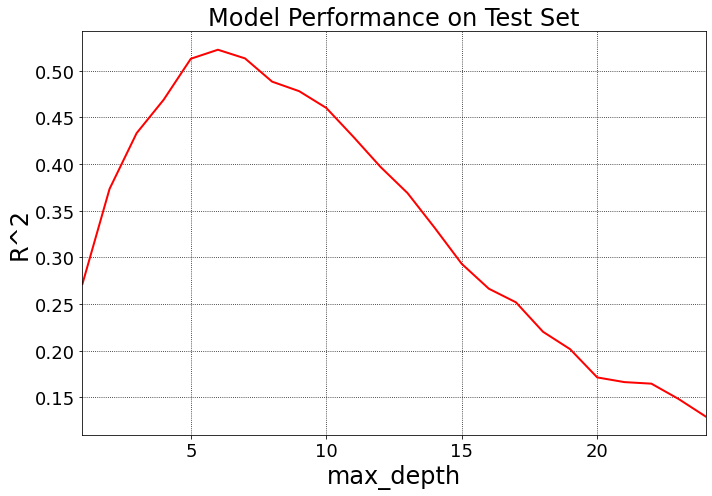

In [78]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                       figsize = (10,7),
                       facecolor = 'white');
ax.plot(max_depth_range,
       r2_list,
       lw=2,
       color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
       axis = 'both',
       zorder = 0,
       linestyle = ':',
       color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('R^2', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [79]:
"""
our r-sqaured came out at about .51
the best posssible r-sqaured value for the model would be between .50 and .55 
to avoid data leakage, we will not use hyper paramters for our model, and favor the features we chose from model 24
for future analysis, we will devise a model that has an r-squared of .55 

"""

'\nour r-sqaured came out at about .51\nthe best posssible r-sqaured value for the model would be between .50 and .55 \nto avoid data leakage, we will not use hyper paramters for our model, and favor the features we chose from model 24\n\n'

# WHat we want to show to our stakeholders: given a house with these attributes, the price will be blank 

In [83]:
#reg.fit(X_train, y_train)

X_test1 = X_test.copy()


In [87]:
# making a fake data frame 
example_sq_live = [2080]
example_data = pd.DataFrame(example_sq_live, columns=['sqft_living'])
example_grade = [7]
example_data['grade_num'] = example_grade 
example_water = [0]
example_data['Waterfront'] = example_water 
example_liv15 = [1905]
example_data["sqft_living15"] = example_liv15
example_above = [1675]
example_data["sqft_above"] = example_above
example_zip = [0]
example_data["zip_city"] = example_zip 
example_data


,sqft_living,grade_num,Waterfront,sqft_living15,sqft_above,zip_city
0,2080,7,0,1905,1675,0


In [88]:

df3 = pd.concat([example_data, X_test1], ignore_index = True)
df3.reset_index()


,index,sqft_living,grade_num,Waterfront,sqft_living15,sqft_above,zip_city
0,0,2080.00000,7.00000,0,1905.00000,1675.00000,0
1,1,860.00000,6.00000,0,1300.00000,860.00000,0
2,2,3210.00000,10.00000,0,3330.00000,3210.00000,0
3,3,2420.00000,8.00000,0,2690.00000,2420.00000,0
4,4,2210.00000,7.00000,0,2110.00000,1450.00000,0
...,...,...,...,...,...,...,...
4866,4866,2110.00000,8.00000,0,1780.00000,2110.00000,0
4867,4867,1450.00000,9.00000,0,1620.00000,1110.00000,1
4868,4868,1780.00000,7.00000,0,1780.00000,1210.00000,0
4869,4869,2160.00000,7.00000,0,1880.00000,1460.00000,1


In [113]:

main_model.predict(df3.iloc[0].values.reshape(1,-1))
#THE PRICE FOR THE FAKE DATA

array([[3.6283693e+08]])

# Model 6 Time!!! YAY!!! I AM SO HAPPY RN EVERYTHING IIS FINE OK

In [132]:
features6 = ['sqft_living', 'grade_num']
X6 = clean_df.loc[:, features6]
y6 = clean_df.loc[:, ['price']]

In [133]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, random_state=0, train_size = .75)

In [134]:
X_train6.shape

(14609, 2)

In [135]:
X_test6.shape

(4870, 2)

In [136]:
y_test6.shape

(4870, 1)

In [137]:
y_train6.shape

(14609, 1)

In [138]:
model6 = LinearRegression()
model6.fit(X_train6, y_train6)

LinearRegression()

In [139]:
model6.predict(X_test6[0:10])

array([[225286.48206744],
       [854758.948391  ],
       [584688.16003974],
       [471115.38220164],
       [446752.41230499],
       [474015.73576077],
       [351620.81556569],
       [428190.14952659],
       [486076.13902949],
       [832837.34302125]])

In [140]:
model6.predict(X_test6.iloc[0].values.reshape(1,-1))

array([[225286.48206744]])

In [141]:
#r^squared
score6 = model6.score(X_test6, y_test6)
print(score6)

0.4311121678343248


In [142]:
#RMSE

metrics.mean_squared_error(y_test6, model6.predict(X_test6), squared= False)

181678.3761404355

# Graphing bc you people cant read or write 
# model 24

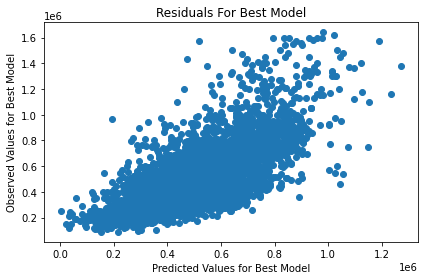

In [147]:
#need to graph y_hat vs y_observed or whatever that means 
#model 24
y_hat = main_model.predict(X_test)
y = y_test 

fig, ax = plt.subplots()
ax.scatter(x=y_hat, y=y_test)
ax.set_xlabel("Predicted Values for Best Model")
ax.set_ylabel("Observed Values for Best Model")
ax.set_title('Residuals For Best Model')
fig.tight_layout()

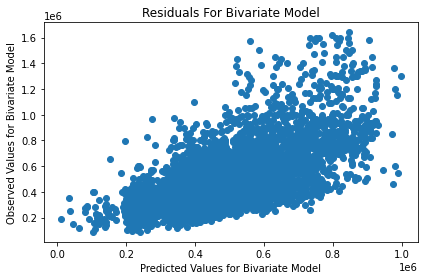

In [148]:
#model 6 
y_hat = model6.predict(X_test6)
y = y_test6 

fig, ax = plt.subplots()
ax.scatter(x=y_hat, y=y_test)
ax.set_xlabel("Predicted Values for Bivariate Model")
ax.set_ylabel("Observed Values for Bivariate Model")
ax.set_title('Residuals For Bivariate Model')
fig.tight_layout()

In [149]:
clean_df['price'].mean()

488722.09102109965

# EDA VIZ

<AxesSubplot:xlabel='grade_num', ylabel='price'>

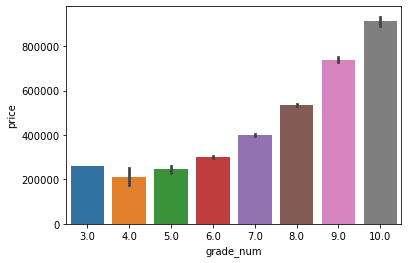

In [155]:
#grade num



sns.barplot(data=clean_df, x="grade_num", y="price")


In [ ]:
#sqft living 
sns.barplot(data=clean_df, x="sqft_living", y="price")

In [ ]:
#zip_city
clean_df.head()

In [153]:
#sqft_living15

In [154]:
#sqft_above

In [ ]:
#water front